In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import pickle
import os
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = "drive/MyDrive/cs418_proj/data/"

Mounted at /content/drive


In [3]:
# utils to cache varaibles to file

def load_from_file(fn):
  if not os.path.exists(path + fn):
    return False
  with open(path + fn, 'rb') as file:
    return pickle.load(file)

def save_to_file(key, data):
  with open(path + key, 'wb') as file:
    pickle.dump(data, file)

def file_exists(fn):
  return os.path.exists(path + fn)

the columns ID, Case Number, X Coordinate, Y Coordinate, Location are dropped because not interenting statistics-wise or redundant.


Since the pre-processing takes quite a lot of time, we store the proprocessed datasets leveraging the pickle library in order to retrieve them faster next time:

In [4]:
remove = ['ID', 'Case Number', 'X Coordinate', 'Y Coordinate', 'Location']


if file_exists("2001-2023-preprocessed"):
  data_all = load_from_file("2001-2023-preprocessed")
  data_2020 = load_from_file("2020-preprocessed")
  data_2021 = load_from_file("2021-preprocessed")
  data_2022 = load_from_file("2022-preprocessed")
  print("Datasets loaded from file")
else:
  data_2020 = pd.read_csv(path + '2020.csv')
  data_2021 = pd.read_csv(path + '2021.csv')
  data_2022 = pd.read_csv(path + '2022.csv')
  data_all = pd.read_csv(path + "2001-2023.csv")

  datasets = (data_2020, data_2021, data_2022, data_all)

  print("Preprocessing datasets...")
  for d in datasets:
    # remove redundant columns
    d.drop(columns=remove, inplace=True)

    # convert to datetime
    d['Date'] = pd.to_datetime(d['Date'])

  save_to_file("2001-2023-preprocessed", data_all)
  save_to_file("2020-preprocessed", data_2020)
  save_to_file("2021-preprocessed", data_2021)
  save_to_file("2022-preprocessed", data_2022)
  print("Datasets saved to file")


Datasets loaded from file


# Historical analysis of employment data and crime rate


Here we want to analyze the relationship between employment status and the crimes committed over time.
To do this we use a [new dataset](https://ides.illinois.gov/resources/labor-market-information/laus/chicago-metropolitan-area-unemployment-rates.html) that hold the following indicators:
date: Represents the date in string format.

- **`date`:** Represents the date in string format.

- **`labor_force`:** Indicates the total number of individuals in the labor force for a given date. This includes both employed and unemployed individuals.

- **`labor_force_participation_rate`:** Represents the labor force participation rate, which is the percentage of the working-age population (16 years and older) that is either employed or actively seeking employment.

- **`employed`:** Represents the number of individuals who are currently employed.

- **`employment_participation_rate`:** Indicates the employment participation rate, which is the percentage of the working-age population that is currently employed.

- **`unemployed`:** Represents the number of individuals who are unemployed, i.e., those who are actively seeking employment but are currently without a job.

- **`unemployment_rate`:** Represents the unemployment rate in the Chicago area, which is the percentage of the labor force that is unemployed.

- **`il_rate`:** Represents the unemployment rate in the whole Illinois state

Our hypothesis is that unemployment and crime rate are positively correlated

In [6]:
employment_df = pd.read_excel(path + 'chicago_labor_data.xls')

In [ ]:
# preprocess employment dataset
employment_df = employment_df.drop(range(8))
employment_df.rename(columns={'Chicago-Naperville-Arlington Heights, IL Metropolitan Division': 'date'}, inplace=True)
employment_df.rename(columns={'Unnamed: 1': 'labor_force',
                           'Unnamed: 2': 'labor_force_participation_rate',
                           'Unnamed: 3': 'employed',
                           'Unnamed: 4': 'employment_participation_rate',
                           'Unnamed: 5': 'unemployed',
                           'Unnamed: 6': 'unemployment_rate',
                           'Unnamed: 7': 'il_rate',
                           }, inplace=True)

employment_df['Date'] = employment_df['date'].astype('datetime64')
employment_df['labor_force'] = employment_df['labor_force'].astype('int64')
employment_df['labor_force_participation_rate'] = employment_df['labor_force_participation_rate'].astype('float')
employment_df['employed'] = employment_df['employed'].astype('int64')
employment_df['employment_participation_rate'] = employment_df['employment_participation_rate'].astype('float')
employment_df['unemployed'] = employment_df['unemployed'].astype('int64')
employment_df['unemployment_rate'] = employment_df['unemployment_rate'].astype('float')
employment_df['il_rate'] = employment_df['il_rate'].astype('float')
employment_df.head()

,date,labor_force,labor_force_participation_rate,employed,employment_participation_rate,unemployed,unemployment_rate,il_rate,Date
8,2023-08-01 00:00:00,3795600,65.7,3607500,62.4,188100,5.0,5.3,2023-08-01
9,2023-07-25 00:00:00,3813300,65.9,3662600,63.3,150700,4.0,4.5,2023-07-25
10,2023-06-01 00:00:00,3836700,66.3,3672200,63.5,164500,4.3,4.5,2023-06-01
11,2023-05-08 00:00:00,3796600,65.6,3674600,63.5,122000,3.2,3.6,2023-05-08
12,2023-04-01 00:00:00,3837100,66.3,3712800,64.1,124300,3.2,3.7,2023-04-01


In [ ]:
# Convert 'Date' to datetime in both DataFrames
employment_df['Date'] = pd.to_datetime(employment_df['Date'])
data_all['Date'] = pd.to_datetime(data_all['Date'])

# Extract month and year from the 'Date' column
employment_df['YearMonth'] = employment_df['Date'].dt.to_period("M")
data_all['YearMonth'] = data_all['Date'].dt.to_period("M")

# Count the number of crimes for each month
crime_counts = data_all.groupby('YearMonth').size().reset_index(name='CrimeCount')

# Merge DataFrames on 'YearMonth'
merged_df = pd.merge(employment_df, crime_counts, on='YearMonth', how='inner')

merged_df

,date,labor_force,labor_force_participation_rate,employed,employment_participation_rate,unemployed,unemployment_rate,il_rate,Date,YearMonth,CrimeCount
0,2023-08-01 00:00:00,3795600,65.7,3607500,62.4,188100,5.0,5.3,2023-08-01,2023-08,23862
1,2023-07-25 00:00:00,3813300,65.9,3662600,63.3,150700,4.0,4.5,2023-07-25,2023-07,23757
2,2023-06-01 00:00:00,3836700,66.3,3672200,63.5,164500,4.3,4.5,2023-06-01,2023-06,22470
3,2023-05-08 00:00:00,3796600,65.6,3674600,63.5,122000,3.2,3.6,2023-05-08,2023-05,22073
4,2023-04-01 00:00:00,3837100,66.3,3712800,64.1,124300,3.2,3.7,2023-04-01,2023-04,20621
...,...,...,...,...,...,...,...,...,...,...,...
267,2001-05-01 00:00:00,3753200,69.4,3553000,65.7,200300,5.3,4.9,2001-05-01,2001-05,41839
268,2001-04-01 00:00:00,3753100,69.4,3536600,65.4,216400,5.8,5.2,2001-04-01,2001-04,40091
269,2001-03-01 00:00:00,3766000,69.7,3546100,65.6,219900,5.8,5.6,2001-03-01,2001-03,40567
270,2001-02-01 00:00:00,3753700,69.5,3541000,65.5,212600,5.7,5.5,2001-02-01,2001-02,33787


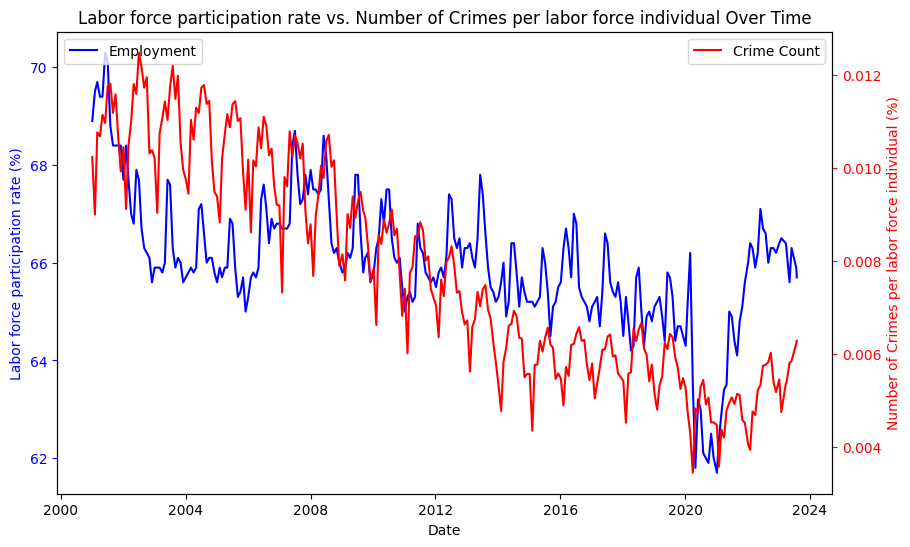

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(merged_df['Date'], merged_df['labor_force_participation_rate'], color='blue', label='Employment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Labor force participation rate (%)', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(merged_df['Date'], merged_df['CrimeCount'] / merged_df['labor_force'], color='red', label='Crime Count')
ax2.set_ylabel('Number of Crimes per labor force individual (%)', color='red')
ax2.tick_params('y', colors='red')
ax2.legend(loc='upper right')

plt.title('Labor force participation rate vs. Number of Crimes per labor force individual Over Time')
plt.show()


229 272


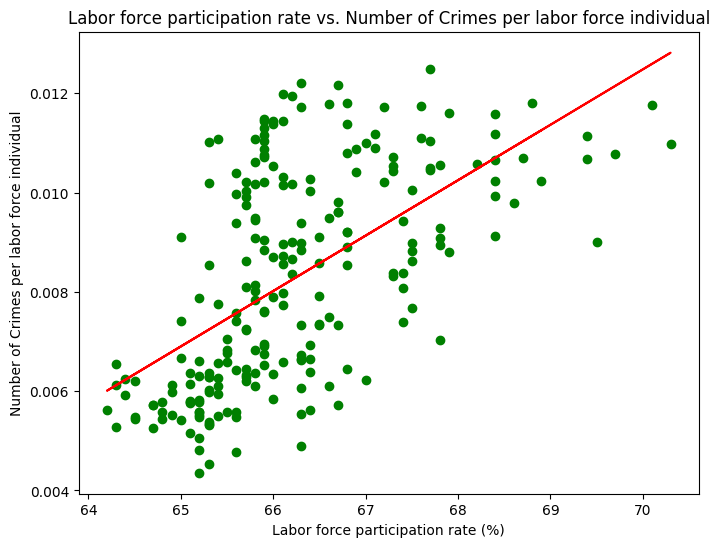

In [ ]:
from scipy.stats import linregress

# Scatter plot
merged_df_before_2020 = merged_df[merged_df['date'] < datetime.datetime.strptime('2020-02-01', '%Y-%m-%d')]
print(len(merged_df_before_2020), len(merged_df))

plt.figure(figsize=(8, 6))
plt.scatter(merged_df_before_2020['labor_force_participation_rate'], merged_df_before_2020['CrimeCount'] / merged_df_before_2020['labor_force'], color='green', marker='o')

# Fit a line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(merged_df_before_2020['labor_force_participation_rate'], merged_df_before_2020['CrimeCount'] / merged_df_before_2020['labor_force'])
line = slope * merged_df_before_2020['labor_force_participation_rate'] + intercept

plt.plot(merged_df_before_2020['labor_force_participation_rate'], line, color='red', label='Linear Fit')

plt.title('Labor force participation rate vs. Number of Crimes per labor force individual')
plt.xlabel('Labor force participation rate (%)')
plt.ylabel('Number of Crimes per labor force individual')
plt.show()


# ML Models



## Predict the crime category based on Location and Time
In this section we are going to train a Decision Tree classifier to predict the category of a specific crime based on the Location and the Time when it occurred. This could be a valuable tool for understanding the needs of a victim calling 911 without being able to speak.

In [ ]:
df = data_2022
df = df.dropna()

# convert date from string to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour

# scale latitude and longitude in [-1, 1]
scaler = StandardScaler()
df['Latitude'] = scaler.fit_transform(df['Latitude'].values.reshape(-1, 1))
df['Longitude'] = scaler.fit_transform(df['Longitude'].values.reshape(-1, 1))

<ipython-input-56-2b2f0a802b9d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-56-2b2f0a802b9d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-56-2b2f0a802b9d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-56-2b2f0a8

First, we analyze the distributions of the available crime types

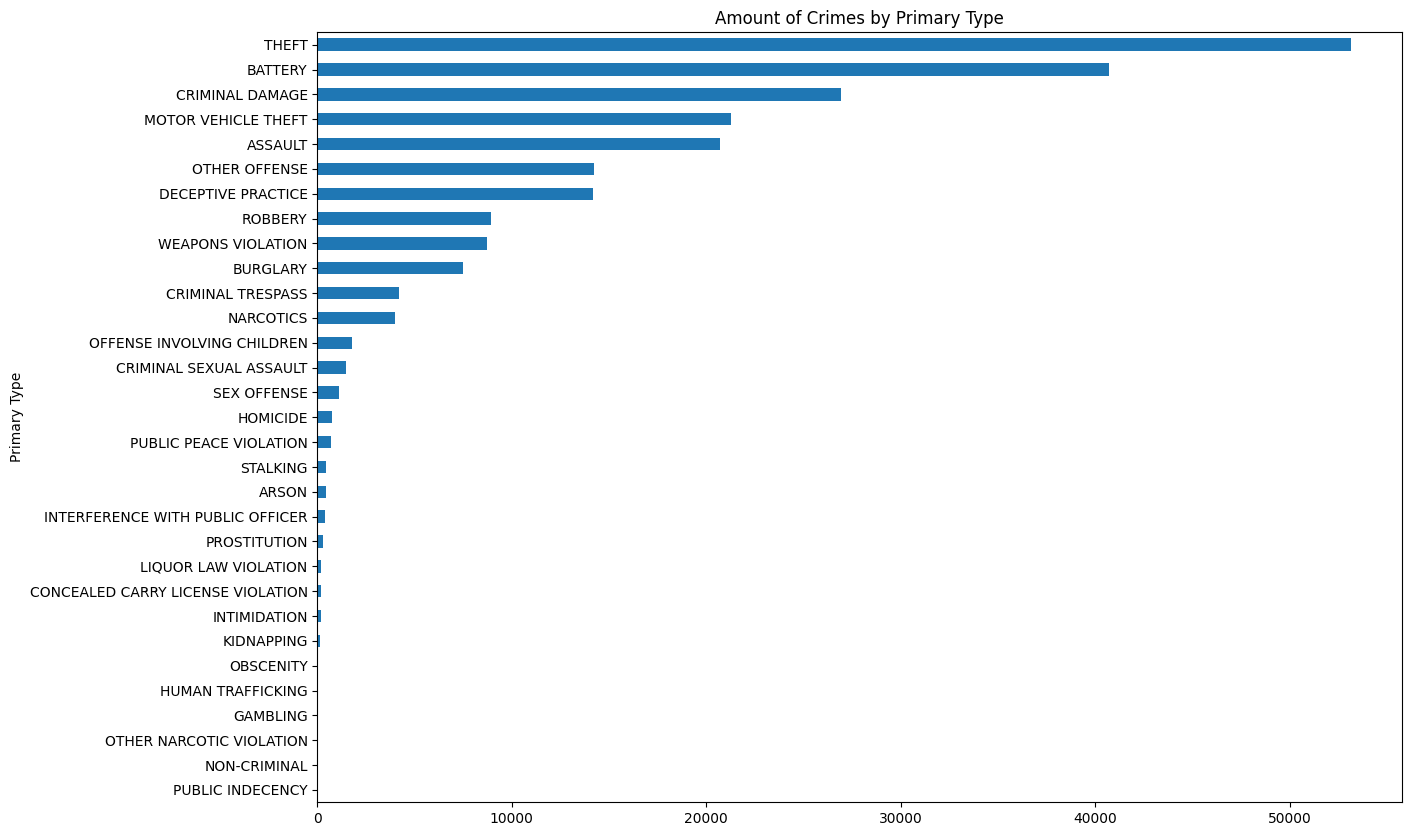

In [ ]:
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In order to reduce the dataset, we random sample 50k examples

In [ ]:
sampled_df = df.sample(n=50000, random_state=42)

We are going to group some of the Crime Types in macro classes ("Crime Category"):
1. Violent Crimes:
HOMICIDE
CRIM SEXUAL ASSAULT
ROBBERY
BATTERY
ASSAULT

2. Property Crimes:
THEFT
MOTOR VEHICLE THEFT
BURGLARY
CRIMINAL DAMAGE
CRIMINAL TRESPASS
DECEPTIVE PRACTICE

3. Drug-Related Crimes:
NARCOTICS

4. Public Order Crimes:
INTERFERENCE WITH PUBLIC OFFICER
PUBLIC PEACE VIOLATION
LIQUOR LAW VIOLATION
PROSTITUTION
GAMBLING
WEAPONS VIOLATION

5. Crimes Involving Children:
OFFENSE INVOLVING CHILDREN

6. Other Crimes:
ARSON
OTHER OFFENSE

the remeining crime types will be dropped because they are not frequent enough.

In [ ]:
crime_type_groups = {
    'Violent Crimes': ['HOMICIDE', 'CRIM SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT'],
    'Property Crimes': ['THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE'],
    'Drug-Related Crimes': ['NARCOTICS'],
    'Public Order Crimes': ['INTERFERENCE WITH PUBLIC OFFICER', 'PUBLIC PEACE VIOLATION', 'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'GAMBLING', 'WEAPONS VIOLATION'],
    'Crimes Involving Children': ['OFFENSE INVOLVING CHILDREN'],
    'Other Crimes': ['ARSON', 'OTHER OFFENSE']
}

def categorize_crime(primary_type):
    for category, crime_types in crime_type_groups.items():
        if primary_type in crime_types:
            return category
    return 'Other'

sampled_df['Crime Category'] = sampled_df['Primary Type'].apply(categorize_crime)

filtered_df = sampled_df[sampled_df['Crime Category'] != 'Other']
filtered_df['Crime Category'].value_counts()

Property Crimes              27307
Violent Crimes               15426
Other Crimes                  3109
Public Order Crimes           2189
Drug-Related Crimes            852
Crimes Involving Children      357
Name: Crime Category, dtype: int64

Now we create a Dummy Classifier to be used as baseline for our classifier.

In [ ]:
filtered_df['Location Description'] = pd.factorize(filtered_df["Location Description"])[0]
filtered_df['District'] = pd.factorize(filtered_df["District"])[0]
filtered_df['Block'] = pd.factorize(filtered_df["Block"])[0]

#X = filtered_df[['Latitude', 'Longitude', 'Month', 'Day', 'Hour', 'Location Description', 'Beat']].values
X = filtered_df[['Month', 'Hour', 'Location Description', 'Beat', 'Domestic', 'Block', 'District', 'Community Area']].values

y = filtered_df['Crime Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy_classifier = DummyClassifier(strategy="most_frequent")

dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Dummy Classifier Accuracy: {accuracy:.2f}')

Dummy Classifier Accuracy: 0.56


<ipython-input-60-f1a3e5d1c9b2>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-60-f1a3e5d1c9b2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-60-f1a3e5d1c9b2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now, we train the decision tree. We select the hyperparameters by performing a grid search and train based on the optimal hyperparameters identified.


In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['entropy'],
    'max_depth': [None],
    'min_samples_split': [300, 400, 500, 600],
    'min_samples_leaf': [2, 16, 30, 32, 34, 36, 40],
}

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

best_decision_tree = DecisionTreeClassifier(random_state=42, **best_params)
best_decision_tree.fit(X_train, y_train)
y_pred = best_decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Tuned Decision Tree Accuracy: {accuracy:.2f}')

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 36, 'min_samples_split': 300}
Tuned Decision Tree Accuracy: 0.67


## Arrest prediction
In this section we want to train a classifier for the 'Arrest' feature of the crime dataset.

As before, we first train a dummy classifier as baseline

In [ ]:
X = data_all[['Primary Type', 'Beat', 'Location Description', 'Community Area', 'Latitude', 'Longitude', 'Domestic', 'Description']]
X['Primary Type'] = pd.factorize(X["Primary Type"])[0]
X['Location Description'] = pd.factorize(X["Location Description"])[0]
X['Description'] = pd.factorize(X["Description"])[0]

y = data_all['Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy_classifier = DummyClassifier(strategy="most_frequent")

dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Dummy Classifier Accuracy: {accuracy:.2f}')

<ipython-input-62-76ed4d83acaf>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-76ed4d83acaf>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-76ed4d83acaf>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Dummy Classifier Accuracy: 0.74


We then train a neural network to classify the arrests.
The architecture we work with consists of 6 fully connected layers.

In [ ]:
X = sampled_df[['Primary Type', 'Beat', 'Location Description', 'Community Area', 'Latitude', 'Longitude', 'Domestic', 'Description']]
X['Primary Type'] = pd.factorize(X["Primary Type"])[0]
X['Location Description'] = pd.factorize(X["Location Description"])[0]
X['Description'] = pd.factorize(X["Description"])[0]
y = sampled_df['Arrest']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dense(36, activation='relu'),
    tf.keras.layers.Dense(72, activation='relu'),
    tf.keras.layers.Dense(36, activation='relu'),
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

<ipython-input-63-402c9d2e08f1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-402c9d2e08f1>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-402c9d2e08f1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/50
400/400 [==============================] - 5s 4ms/step - loss: 0.3376 - accuracy: 0.8791 - val_loss: 0.3129 - val_accuracy: 0.8839
Epoch 2/50
400/400 [==============================] - 2s 4ms/step - loss: 0.2976 - accuracy: 0.8858 - val_loss: 0.3058 - val_accuracy: 0.8865
Epoch 3/50
400/400 [==============================] - 2s 4ms/step - loss: 0.2906 - accuracy: 0.8934 - val_loss: 0.3021 - val_accuracy: 0.8939
Epoch 4/50
400/400 [==============================] - 1s 4ms/step - loss: 0.2843 - accuracy: 0.9007 - val_loss: 0.2967 - val_accuracy: 0.9010
Epoch 5/50
400/400 [==============================] - 1s 4ms/step - loss: 0.2781 - accuracy: 0.9060 - val_loss: 0.2904 - val_accuracy: 0.9023
Epoch 6/50
400/400 [==============================] - 1s 4ms/step - loss: 0.2711 - accuracy: 0.9107 - val_loss: 0.2856 - val_accuracy: 0.9111
Epoch 7/50
400/400 [==============================] - 1s 4ms/step - loss: 0.2662 - accuracy: 0.9129 - val_loss: 0.2760 - val_accuracy: 0.9135
Epoch 

# Crime rate prediction - Pietro

Here we want to fit an ARIMA model over the historical trends of our data and find out its performance on our data.

First of all we gather the daily, weekly and monthly counts of crimes and plot them:

In [7]:
daily_crime_count = data_all.groupby(data_all['Date'].dt.date)['Date'].count()
weekly_crime_count = data_all.resample('W', on='Date')['Date'].count()
monthly_crime_count = data_all.resample('M', on='Date')['Date'].count()

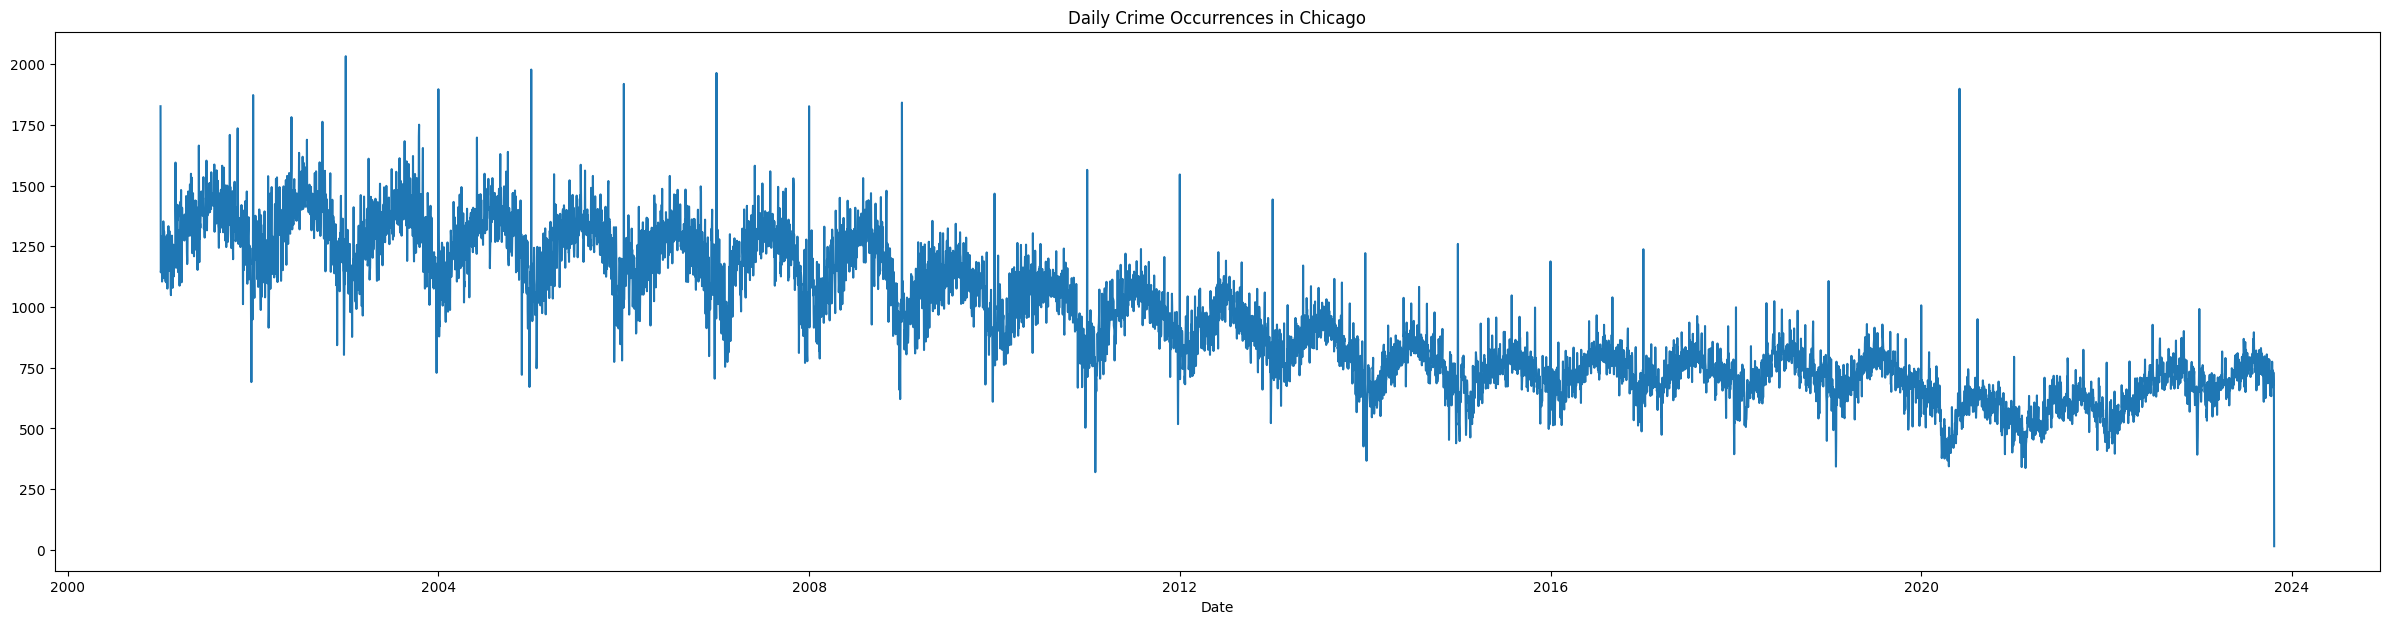

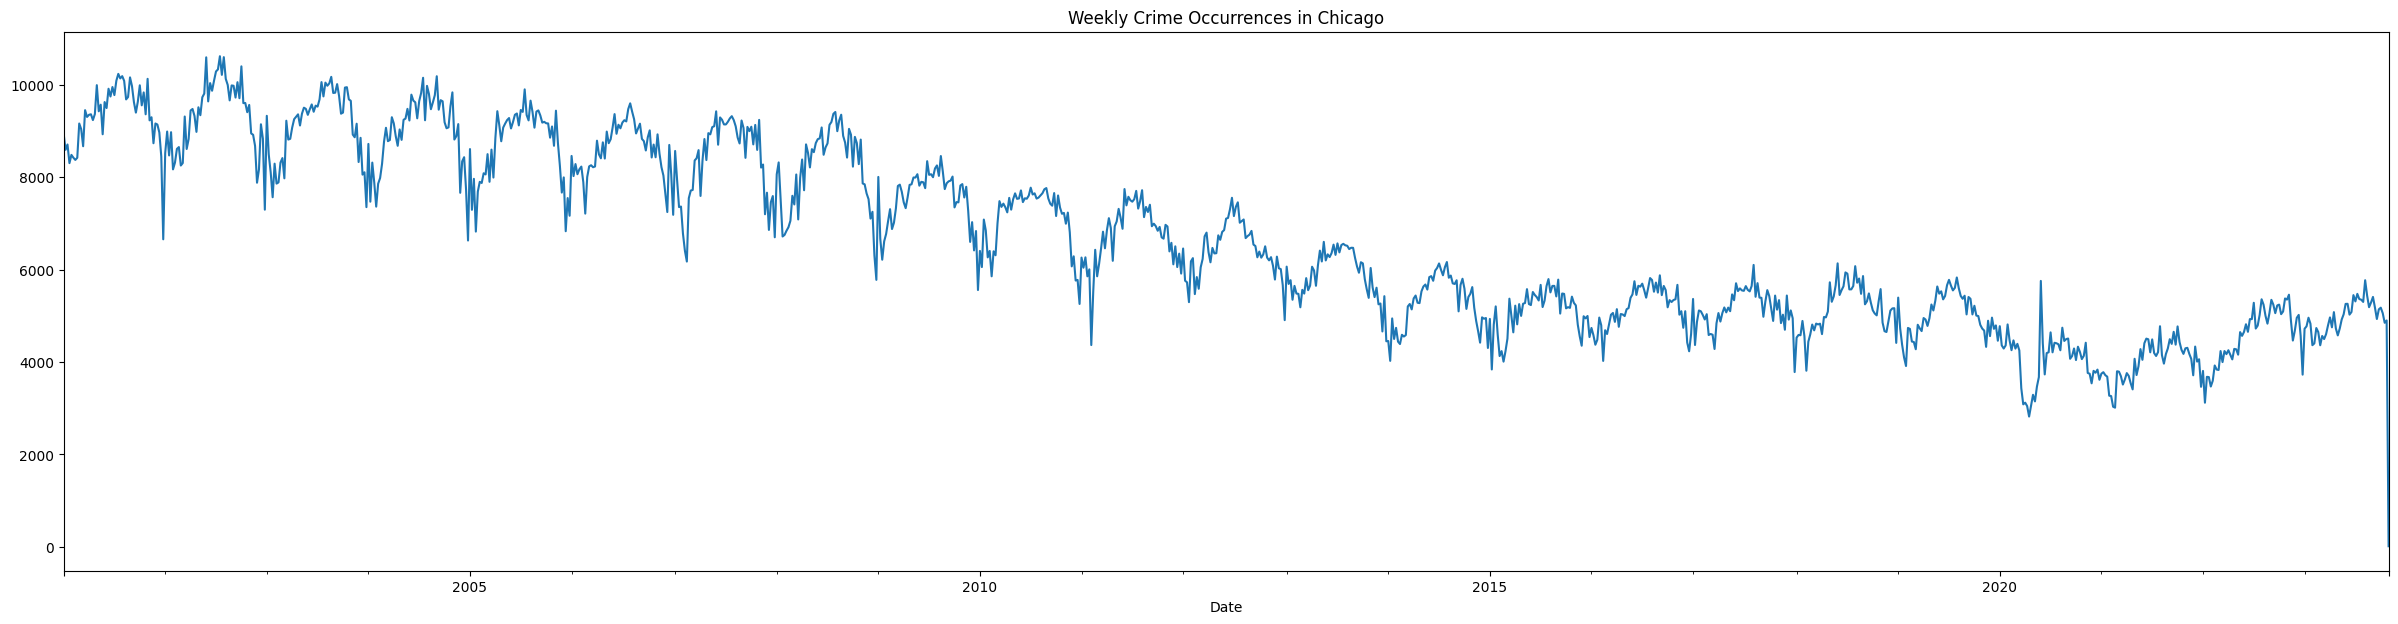

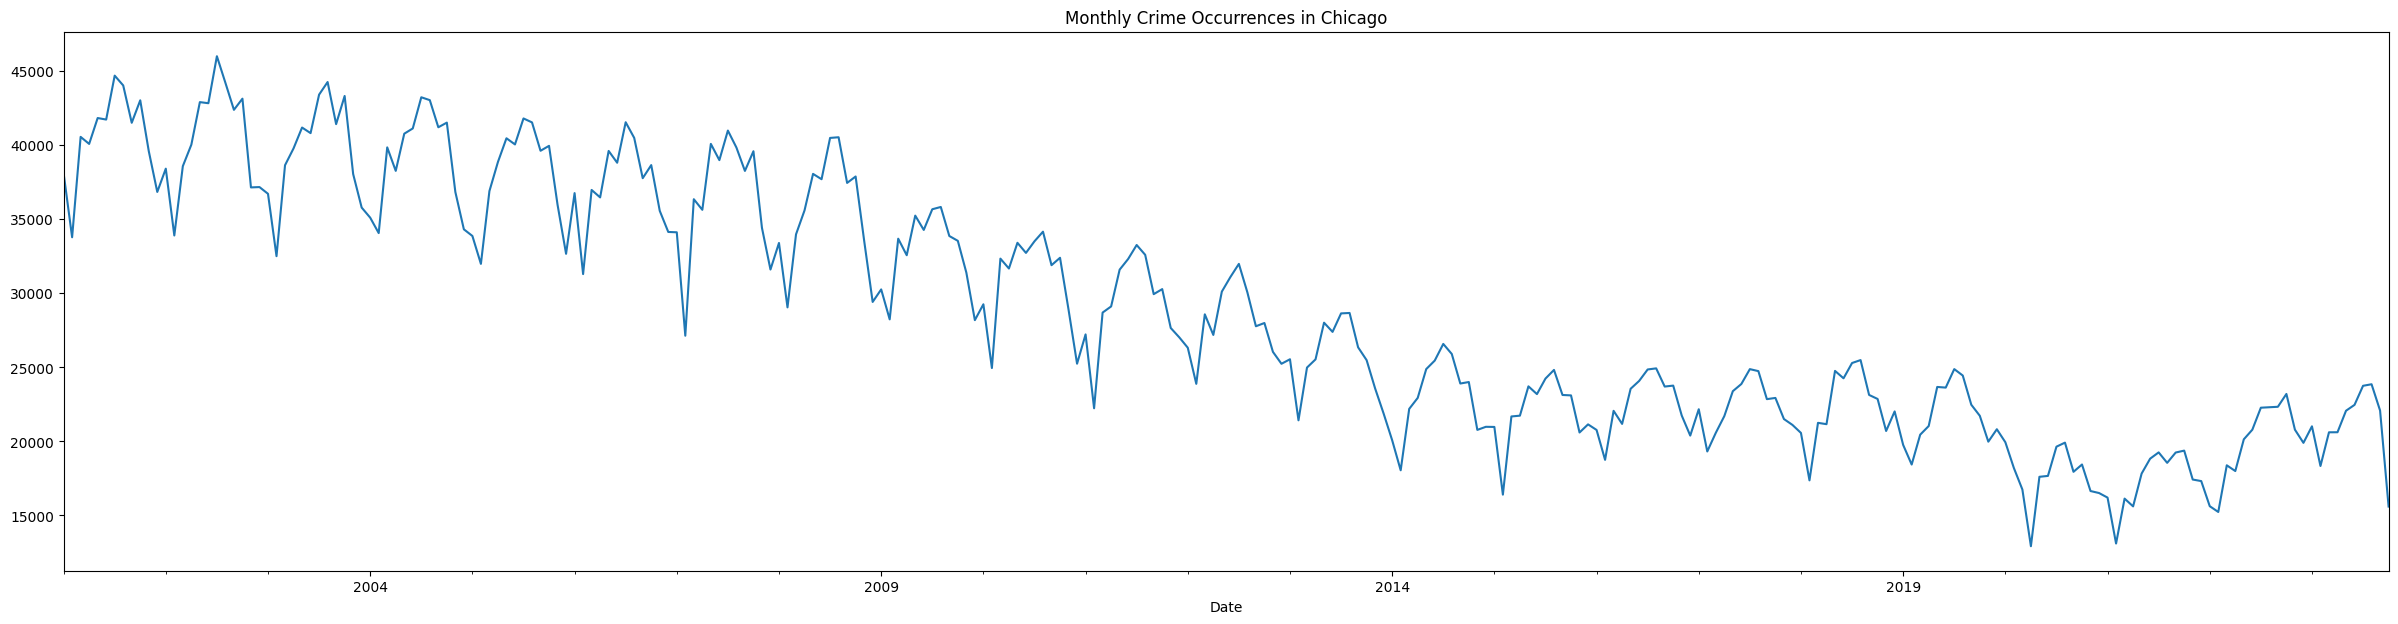

In [8]:
daily_crime_count.plot(
    figsize=(30, 7),
    title="Daily Crime Occurrences in Chicago")
plt.show()

weekly_crime_count.plot(
    figsize=(30, 7),
    title="Weekly Crime Occurrences in Chicago")
plt.show()

monthly_crime_count.plot(
    figsize=(30, 7),
    title="Monthly Crime Occurrences in Chicago")
plt.show()

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


if model := load_from_file('LSTM.pkl'):
  print('model loaded from file')
else:
  data = np.array(daily_crime_count).reshape(-1, 1)

  scaler = MinMaxScaler(feature_range=(0, 1))
  data_normalized = scaler.fit_transform(data)

  def prepare_data(data, time_steps):
      X, y = [], []
      for i in range(time_steps, len(data)):
          a = data[i - time_steps : i, 0]
          X.append(a)
          y.append(data[i, 0])
      return np.array(X), np.array(y)

  time_steps = 365

  X, y = prepare_data(data_normalized, time_steps)

  tr_portion = .9
  train_size = int(len(X) * tr_portion)
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  model = Sequential()
  model.add(LSTM(units=2500, activation='relu', input_shape=(time_steps, 1), return_sequences=True))
  model.add(LSTM(units=2500, activation='relu'))
  model.add(Dense(units=2000))
  model.add(Dense(units=2000))
  model.add(Dense(units=1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test), verbose=1)

  # Save the model
  save_to_file('LSTM.pkl', model)


if os.path.exists(path + 'LSTM_train_pred.pkl'):
  train_predict = load_from_file('LSTM_train_pred.pkl')
  print('train_predict loaded from file')
else:
  train_predict = model.predict(X_train)
  save_to_file('LSTM_train_pred.pkl', train_predict)

if os.path.exists(path + 'LSTM_test_pred.pkl'):
  test_predict = load_from_file('LSTM_test_pred.pkl')
  print('test_predict loaded from file')
else:
  test_predict = model.predict(X_test)
  save_to_file('LSTM_test_pred.pkl', test_predict)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


# Calculate MAE
train_score = np.sqrt(mean_absolute_error(y_train[0], train_predict[:, 0]))
print('Train MAE:', train_score)

test_score = np.sqrt(mean_absolute_error(y_test[0], test_predict[:, 0]))
print('Test MAE:', test_score)



model loaded from file
train_predict loaded from file
test_predict loaded from file
Train MAE: 34.79287167082178
Test MAE: 42.56302256859679


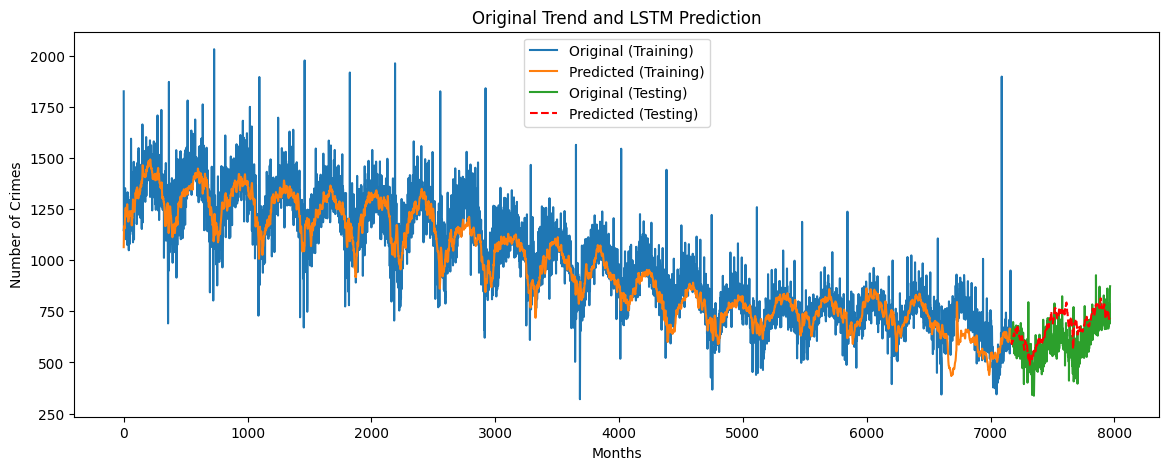

In [25]:
plt.figure(figsize=(14, 7))

plt.plot(range(train_size), (data[:train_size]), label='Original (Training)')
plt.plot(range(train_size), train_predict.flatten(), label='Predicted (Training)')


test_range = range(train_size, len(data) - time_steps)
plt.plot(test_range, (data[train_size:len(data) - time_steps]), label='Original (Testing)')
plt.plot(test_range, test_predict.flatten(), label='Predicted (Testing)', linestyle='dashed', color='red')

plt.title('Original Trend and LSTM Prediction on the Last 20%')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
plt.legend()

plt.show()



\